# Readers

> IR spectrometers readers

In [ ]:
#| default_exp readers

In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev.cli import *

%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from brukeropusreader import read_file
from specdal import Collection, Spectrum, read
import pandas as pd
import numpy as np
from typing import Tuple, Dict, Callable
import pandas as pd
import matplotlib.pyplot as plt

## Readers

In [ ]:
#| export
def read_opus(
    fname:str # file name
) -> Tuple: # (spectrum, wavenumbers) as `np.ndarray`
    """OPUS (Bruker Optics) infrared spectra reader
    
    It uses patched `brukeropusreader` third party Python package. 
    
    To install it run: 
    `conda install -c "spectrocat/label/dev" brukeropusreader`
    """
    f = read_file(fname)
    return f['AB'], f.get_range('AB')    

In [ ]:
#|eval: false
fname = 'files/32990XS01.0'
spectrum, wn = read_opus(fname)
print('spectrum:', spectrum)
print('wavenumbers: ', wn)

spectrum: [0.11326975 0.11811147 0.12199899 ... 1.64596999 1.63877058 1.63174832]
wavenumbers:  [7498.04282256 7496.11431361 7494.18580465 ...  603.62330336  601.6947944
  599.76628545]


In [ ]:
#| export
def set_negative_to_min_positive(arr):
    """
    Ensure all reflectance values > 0
    before applying -log10 absorbance transform
    """
    min_positive = np.min(arr[arr > 0])
    arr[arr < 0] = min_positive
    return arr

In [ ]:
#| export
def read_asd(
    fname:str, # file name
    wl_range:list=[500, 2450] # wavelengh range of interest 
) -> Tuple: # (spectrum, wavenumbers) as `np.ndarray`
    """.asd file infrared spectra reader
    
    It uses patched `SpecDal` third party Python package. 
    
    """
    start, end = wl_range
    c = Collection(name='spectrum')
    spectrum = Spectrum(filepath=fname)
    c.append(spectrum)
    values = set_negative_to_min_positive(c.data.values.squeeze())
    df = pd.DataFrame({'absorbance': -np.log10(values)}, 
                      index=c.data.index)
    
    df = df.loc[start:end,:]
    return df.values.squeeze(), df.index.values

spectrum: [0.82470547 0.82104576 0.81702641 ... 0.61010321 0.6110041  0.61188284]
wavelenghts:  [ 500.  501.  502. ... 2448. 2449. 2450.]


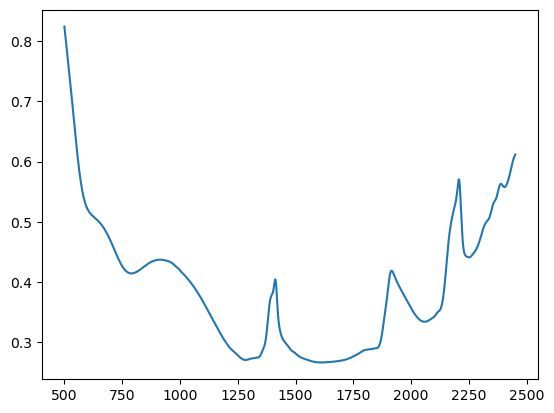

In [ ]:
#|eval: false
fname = 'files/152706MD01.asd'
spectrum, wl = read_asd(fname)
print('spectrum:', spectrum)
print('wavelenghts: ', wl)
plt.plot(wl, spectrum);

In [ ]:
#| export
def read_spectra(
    fname:str # file name
) -> Tuple: # (spectrum, wavenumbers) as `np.ndarray`
    'Read KSSL MIRS data exported as .csv by USDA/NRCS'
    series = pd.read_csv(fname, index_col=0).squeeze("columns")
    return series.values, series.index.values

In [ ]:
#|eval: false
fname = 'files/232985XS03.csv'
spectrum, wn = read_spectra(fname)
print('spectrum:', spectrum)
print('wavenumbers: ', wn)

spectrum: [0.22969 0.22999 0.23026 ... 1.46858 1.45966 1.45319]
wavenumbers:  [3999.72758 3997.79907 3995.87056 ...  603.6233   601.69479  599.76629]


In [ ]:
#| export
def read_spa(filepath):
    '''
    Input
    Read a file (string) *.spa
    ----------
    Output
    Return spectra, wavelength (nm), titles
    '''
    with open(filepath, 'rb') as f:
        f.seek(564)
        Spectrum_Pts = np.fromfile(f, np.int32,1)[0]
        f.seek(30)
        SpectraTitles = np.fromfile(f, np.uint8,255)
        SpectraTitles = ''.join([chr(x) for x in SpectraTitles if x!=0])

        f.seek(576)
        Max_Wavenum=np.fromfile(f, np.single, 1)[0]
        Min_Wavenum=np.fromfile(f, np.single, 1)[0]
        Wavenumbers = np.flip(np.linspace(Min_Wavenum, Max_Wavenum, Spectrum_Pts))
        # print(Wavenumbers)

        f.seek(288);

        Flag=0
        while Flag != 3:
            Flag = np.fromfile(f, np.uint16, 1)

        DataPosition=np.fromfile(f,np.uint16, 1)
        f.seek(DataPosition[0])

        Spectra = np.fromfile(f, np.single, Spectrum_Pts)
    # return Spectra, 1e7/Wavenumbers, SpectraTitles
    # return Spectra, Wavenumbers, SpectraTitles
    return Spectra, Wavenumbers